In [1]:
# Install torch in jupyter kernel if needed
# !pip freeze

In [2]:
# Init import paths
import sys
from pathlib import Path

# Add project root to Python path
project_root = str(Path().resolve().parent)  # Goes up one level from notebook dir
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Load original data to get titles for analysis
import pandas as pd
from sklearn.model_selection import train_test_split

ORIGINAL_DATA_PATH = "../project_data/processed_titles.csv" # Path to your original CSV
TEST_SIZE = 0.1 # MUST MATCH the test_size used in tokenization script
VAL_SIZE = 0.1  # MUST MATCH match the validation split ratio (0.1 of the remaining 90%)
RANDOM_STATE = 42 # MUST MATCH the random_state used in tokenization script


try:
    original_df = pd.read_csv(ORIGINAL_DATA_PATH)
    original_titles = original_df["title"].astype(str).fillna("").tolist()
    original_labels = original_df["label"].tolist() # Also get labels to verify split matches

    # Perform the SAME split as in the tokenization script
    # This will give the original titles/labels split in the same order
    titles_temp, titles_test, labels_temp, labels_test = train_test_split(
        original_titles, original_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=original_labels # Use stratify if used before
    )
    titles_train, titles_val, labels_train, labels_val = train_test_split(
        titles_temp, labels_temp, test_size=(VAL_SIZE / (1 - TEST_SIZE)), random_state=RANDOM_STATE, stratify=labels_temp # Calculate val_size relative to temp
    )

    print(f"Original data loaded and re-split. Validation titles count: {len(titles_val)}")

except FileNotFoundError:
    print(f"Error: Original data CSV not found at {ORIGINAL_DATA_PATH}. Cannot display titles for misclassified samples.")
    titles_val = []
except KeyError:
    print(f"Error: 'title' or 'label' column not found in {ORIGINAL_DATA_PATH}. Cannot display titles.")
    titles_val = []
except Exception as e:
    print(f"An error occurred during original data loading/splitting: {e}")
    titles_val = []

Original data loaded and re-split. Validation titles count: 4490


# Discriminator Performance Analysis

In [4]:
import torch
from utils.diagnostics import *
from project_models import Discriminator
from utils.data_loading import get_dataloaders
from tokenizers import Tokenizer

In [5]:
# Configuration
MODEL_PATH = "../project_models/discriminator.pth"
TOKENIZER_PATH = "../project_data/hf_tokenizer.json"
SEQUENCE_LENGTH = 20
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Load tokenizer to get vocab size
try:
    tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
    vocab_size = tokenizer.get_vocab_size()
    print(f"Tokenizer loaded. Vocab size: {vocab_size}")
except FileNotFoundError:
    print(f"Error: Tokenizer not found at {TOKENIZER_PATH}. Cannot initialize model.")
    vocab_size = None

Tokenizer loaded. Vocab size: 10000


In [7]:
# Load trained model
if vocab_size is not None: # Only proceed if tokenizer was loaded
    # Instantiate the model w/ the required arguments
    model = Discriminator(vocab_size=vocab_size, sequence_length=SEQUENCE_LENGTH).to(device)

    # Load the state dictionary
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device)) # Use map_location=device
        print(f"Model loaded successfully from {MODEL_PATH}")
    except FileNotFoundError:
         print(f"Error: Model state dict not found at {MODEL_PATH}. Model initialized but weights not loaded.")
    except Exception as e:
         print(f"Error loading model state dict: {e}")
else:
    print("Skipping model initialization and loading due to missing vocab_size.")


Model loaded successfully from ../project_models/discriminator.pth


In [8]:
# Load data
_, val_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE)

Attempting to load data from ../project_data/processed/...
Data files loaded successfully.
DataLoaders created successfully.
Train dataset size: 35918
Val dataset size: 4490
Test dataset size: 4490


### Basic Evaluation

In [9]:
# Get metrics on validation set
metrics, val_labels, val_probs = evaluate_model(model, val_loader)

In [10]:
print(f"Validation Accuracy: {metrics['accuracy']:.4f}")
print(f"Weighted Avg F1 Score: {metrics['f1_weighted']:.4f}")
print("-" * 30)
print("Per-Class Metrics:")
print(f"  Fake (0.0)  - Precision: {metrics['precision_0']:.4f}, Recall: {metrics['recall_0']:.4f}, F1: {metrics['f1_0']:.4f}")
print(f"  Real (1.0)  - Precision: {metrics['precision_1']:.4f}, Recall: {metrics['recall_1']:.4f}, F1: {metrics['f1_1']:.4f}")

Validation Accuracy: 0.9454
Weighted Avg F1 Score: 0.9454
------------------------------
Per-Class Metrics:
  Fake (0.0)  - Precision: 0.9542, Recall: 0.9408, F1: 0.9475
  Real (1.0)  - Precision: 0.9361, Recall: 0.9505, F1: 0.9432


In [11]:
# Display full classification report
pd.DataFrame(metrics['class_report']).transpose()

,precision,recall,f1-score,support
0.0,0.954212,0.940801,0.947459,2348.000000
1.0,0.936092,0.950514,0.943248,2142.000000
accuracy,0.945434,0.945434,0.945434,0.945434
macro avg,0.945152,0.945657,0.945353,4490.000000
weighted avg,0.945567,0.945434,0.945450,4490.000000


### Visual Diagnostics

Confusion matrix saved to plots/confusion_matrix.svg


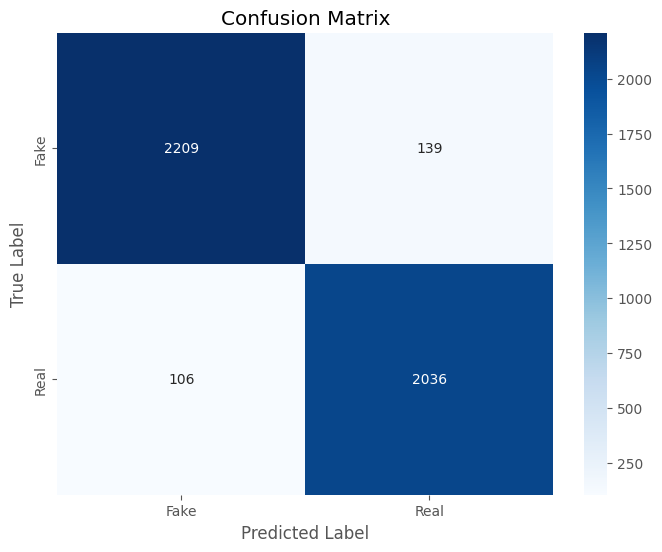

In [12]:
# Confusion Matrix
plot_confusion_matrix(val_labels, val_probs)

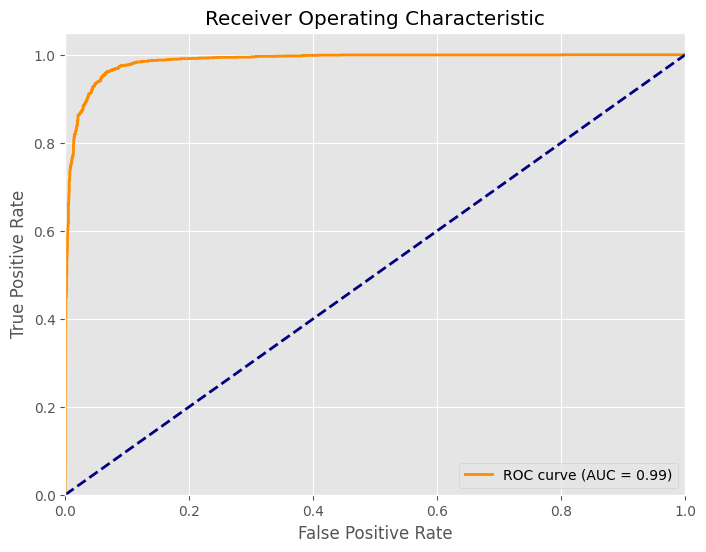

In [15]:
# 2. ROC Curve
plot_roc_curve(val_labels, val_probs)

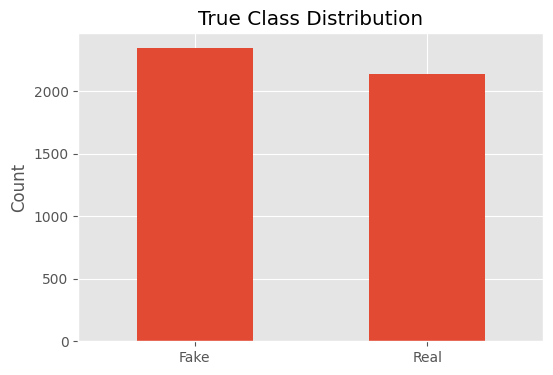

In [16]:
# 3. Class Distribution
plot_class_distribution(val_labels)

### Examples

In [35]:
# Get misclassified examples
# Assuming val_labels and val_probs are correctly obtained from evaluate_model (labels shape (N,), probs shape (N, 1))
# And titles_val is the list of original validation titles

# Ensure val_labels is (N,) numpy array
if isinstance(val_labels, torch.Tensor):
    val_labels_np = val_labels.numpy()
elif val_labels.ndim > 1 and val_labels.shape[1] == 1:
    val_labels_np = val_labels.squeeze(1)
else:
    val_labels_np = val_labels # Assume (N,) numpy

# Ensure val_probs is (N, 1) numpy array
if isinstance(val_probs, torch.Tensor):
    val_probs_np = val_probs.numpy()
elif val_probs.ndim == 1: # If evaluate_model was changed to return (N,)
     val_probs_np = val_probs.reshape(-1, 1)
else:
    val_probs_np = val_probs # Assume (N, 1) numpy


# --- Calculate predictions using thresholding ---
val_preds_np = (val_probs_np.squeeze(1) > 0.5).astype(int) # Shape (N,)
# ---------------------------------------------------------

# Calculate wrong_idx using the CORRECTED predictions (val_preds_np) and true labels (val_labels_np)
wrong_idx = np.where(val_preds_np != val_labels_np)[0] # Compare (N,) vs (N,)

print(f"Found {len(wrong_idx)} misclassified examples.")

Found 245 misclassified examples.


In [39]:
# Display first 5 misclassified samples

if titles_val: # Only proceed if original titles were loaded
    print("\nFirst 5 misclassified titles:")
    # Added min to avoid error if less than 5, already present
    for i_wrong in wrong_idx[:min(len(wrong_idx), 5)]:
        true_label = int(val_labels_np[i_wrong])
        predicted_label = int(val_preds_np[i_wrong]) # Use the corrected val_preds_np
        confidence = val_probs_np[i_wrong].item() # Probability for the positive class (Real)

        original_title = titles_val[i_wrong]

        print(f"Title: \"{original_title}\"")
        print(f"  True: {'Real' if true_label == 1 else 'Fake'}")
        print(f"  Predicted: {'Real' if predicted_label == 1 else 'Fake'}")
        # Print confidence towards the predicted class
        prob_predicted_class = confidence if predicted_label == 1 else (1 - confidence)
        print(f"  Confidence (of predicted class): {prob_predicted_class:.2%}")
        print(f"  (Raw sigmoid output / Prob Real: {confidence:.4f})")
        print("-" * 20)
else:
    print("Original titles not available for display.")


First 5 misclassified titles:
Title: "rbg blasts republicans for crippling the supreme court"
  True: Fake
  Predicted: Real
  Confidence (of predicted class): 98.48%
  (Raw sigmoid output / Prob Real: 0.9848)
--------------------
Title: "palin curtails florida appearances for trump rally after husbands accident"
  True: Real
  Predicted: Fake
  Confidence (of predicted class): 98.10%
  (Raw sigmoid output / Prob Real: 0.0190)
--------------------
Title: "asked about two states netanyahu says he wants to focus on substance not labels"
  True: Real
  Predicted: Fake
  Confidence (of predicted class): 89.55%
  (Raw sigmoid output / Prob Real: 0.1045)
--------------------
Title: "pope orthodox leader make climate change appeal to heal wounded creation"
  True: Real
  Predicted: Fake
  Confidence (of predicted class): 97.89%
  (Raw sigmoid output / Prob Real: 0.0211)
--------------------
Title: "russian court tells aeroflot it cannot tell stewardesses what size clothing to wear"
  True: R

### Test Set Evaluation (Final)

In [19]:
# Final evaluation on held-out test set
test_metrics, _, _ = evaluate_model(model, test_loader)

In [38]:
print(f"\nTEST SET PERFORMANCE")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")


TEST SET PERFORMANCE
Accuracy: 0.9434


Loaded y_train and y_test for balance check.

Train Set Class Distribution:


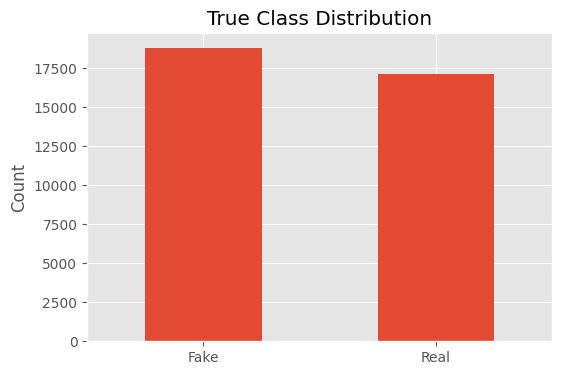


Test Set Class Distribution:


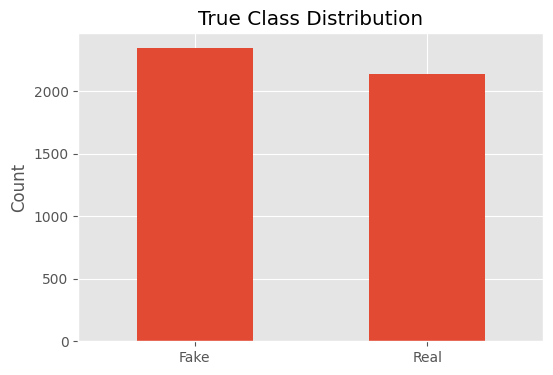

In [42]:
import os
DATA_DIR = "../project_data/processed/"
try:
    y_train_np = np.load(os.path.join(DATA_DIR, "y_train.npy"))
    y_test_np = np.load(os.path.join(DATA_DIR, "y_test.npy"))
    print("Loaded y_train and y_test for balance check.")
except FileNotFoundError as e:
    print(f"Error loading label files for balance check: {e}")
    y_train_np = np.array([]) # Ensure they are arrays even if load fails
    y_test_np = np.array([])


# Ensure labels are (N,) for plotting if they were (N, 1)
if y_train_np.ndim > 1 and y_train_np.shape[1] == 1:
    y_train_np = y_train_np.squeeze(1)
if y_test_np.ndim > 1 and y_test_np.shape[1] == 1:
    y_test_np = y_test_np.squeeze(1)


print("\nTrain Set Class Distribution:")
plot_class_distribution(y_train_np)

print("\nTest Set Class Distribution:")
plot_class_distribution(y_test_np)